# HSE 2023: Введение в машинное обучение БИ 23/24

## ДЗ 2

# Внимание!
Если в задании просят объяснить что-либо, то это значит, что требуется письменный ответ, который является частью задания и оценивается

Мы только принимаем ipynb ноутбуки. Если вы используете Google Colab, то вам необходимо скачать ноутбук перед сдачей ДЗ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
# from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from math import sqrt
import random
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid")

### Данные

Для этого ДЗ мы будем использовать датасет треков со стримингового сервиса Spotify

**Описание данных**

- **track_id:** The Spotify ID for the track
- **artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;
- **album_name:** The album name in which the track appears
- **track_name:** Name of the track
- **popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
- **duration_ms:** The track length in milliseconds
- **explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
- **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
- **key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
- **loudness:** The overall loudness of a track in decibels (dB)
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
- **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
- **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
- **instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
- **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
- **time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
- **track_genre:** The genre in which the track belongs

**Целевая переменная**
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

In [2]:
data = pd.read_csv('dataset.csv').dropna()

y = data['energy']
X = data.drop(['energy'], axis=1)
columns = X.columns

## Линейная регрессия

#### 0. [0.25 балла] Закодируйте категориальные признаки. Объясните выбранный вами метод.

In [3]:
X.nunique()

artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50696
explicit                2
danceability         1174
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45652
time_signature          5
track_genre           114
dtype: int64

> Видно, что в данных очень много уникальных значений => использование простейших методов, таких как One-Hot Encoding приведет к созданию слишком большого количества столбцов, что может затруднить обучение модели и вызвать проблемы с производительностью.
>
> Поэтому я решил использовать метод Target Encoding, который заключается в замене каждого уникального значения категориального признака на среднее значение целевой переменной. Т.е., каждое уникальное значение будет заменено на число, которое представляет среднюю энергичность для этой категории.

In [4]:
all_categories = ["artists", "album_name", "track_name", "track_genre", "explicit"]
for category in all_categories:
    target_mean = data.groupby(category)['energy'].mean()
    X[category] = data[category].map(target_mean)

#### 1. [0.25 балла] Разбейте данные на train и test с пропорцией 75:25 и random_state=7. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

#### 2. [0.75 балла] Обучите модели на train'е, исключив категориальные признаки, используя библиотеку StatsModels и примените ее к test'у; используйте $RMSE$ и $R ^ 2$ в качестве метрики качества. Попробуйте также применить реализации линейной регрессии из sklearn:

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.03$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.05$
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) with $\alpha = 0.01$, $l_{1}$_$ratio = 0.4$

Не забывайте скейлить данные с помощью StandardScaler перед обучением моделей! 

In [6]:
# Исключаем категориальные признаки и скейлим данные
X_train_without_categorical = X_train
X_test_without_categorical = X_test

for cat in all_categories:
    X_train_without_categorical = X_train_without_categorical.drop([cat], axis=1)
    X_test_without_categorical = X_test_without_categorical.drop([cat], axis=1)

scaler = StandardScaler()
X_train_without_categorical_scaled = scaler.fit_transform(X_train_without_categorical)
X_test_without_categorical_scaled = scaler.fit_transform(X_test_without_categorical)

# Обучаем модель, используя StatsModel
X_train_without_categorical_scaled = sm.add_constant(X_train_without_categorical_scaled)
model = sm.OLS(y_train, X_train_without_categorical_scaled).fit()
# Применяем модель к test-у и получаем RMSE и R^2
X_test_without_categorical_scaled = sm.add_constant(X_test_without_categorical_scaled)
y_pred = model.predict(X_test_without_categorical_scaled)
print(f'FOR StatsModel.OLS: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.LinearRegression
model = LinearRegression().fit(X_train_without_categorical_scaled, y_train)
y_pred = model.predict(X_test_without_categorical_scaled)
print(f'FOR sklearn.LinearRegression: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.Ridge
model = Ridge(alpha=0.03).fit(X_train_without_categorical_scaled, y_train)
y_pred = model.predict(X_test_without_categorical_scaled)
print(f'FOR sklearn.Ridge: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.Lasso
model = Lasso(alpha=0.05).fit(X_train_without_categorical_scaled, y_train)
y_pred = model.predict(X_test_without_categorical_scaled)
print(f'FOR sklearn.Lasso: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.LinearRegression
model = ElasticNet(alpha=0.01, l1_ratio=0.4).fit(X_train_without_categorical_scaled, y_train)
y_pred = model.predict(X_test_without_categorical_scaled)
print(f'FOR sklearn.ElasticNet: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

FOR StatsModel.OLS: RMSE = 0.1216, R^2 = 0.7658

FOR sklearn.LinearRegression: RMSE = 0.1216, R^2 = 0.7658

FOR sklearn.Ridge: RMSE = 0.1216, R^2 = 0.7658

FOR sklearn.Lasso: RMSE = 0.1475, R^2 = 0.6555

FOR sklearn.ElasticNet: RMSE = 0.1226, R^2 = 0.7620



* Худший результат по обоим показателям дала sklearn.Lasso (RMSE=0.1475, R^2=0.6555)
* Лучший -- StatsModel.OLS, sklearn.LinearRegression, sklearn.Ridge (у всех RMSE=0.1216, R^2=0.7658)
* Результат sklearn.ElasticNet несколько ниже, но всё равно неплох (RMSE=0.1226, R^2=0.7620)

Для лучших моделей:

Полученный RMSE = 0.1216, что является хорошим результатом (учитывая, что 0 <= energy <= 1).
Полученный R^2 примерно равен 0.7658 => что примерно 76.6% дисперсии в данных о зависимой переменной объяснено моделью. 
Полученные данные могут свидетельствовать о том, что модель, тренированная на данных без категориальных признаков, уже достаточно валидна для оценки energy, однако около 25% предсказаний будут оказываться ложными.

#### 3. [0.25 балла] Повторите шаги из предыдущего пункта, добавив категориальные признаки. Прокомментируйте изменения значений метрик качества

In [7]:
# Cкейлим данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Обучаем модель, используя StatsModel
X_train_scaled = sm.add_constant(X_train_scaled)
model_ols = sm.OLS(y_train, X_train_scaled).fit()
# Применяем модель к test-у и получаем RMSE и R^2
X_test_scaled = sm.add_constant(X_test_scaled)
y_pred = model_ols.predict(X_test_scaled)
print(f'FOR StatsModel.OLS: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.LinearRegression
model_lr = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model_lr.predict(X_test_scaled)
print(f'FOR sklearn.LinearRegression: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.Ridge
model_ridge = Ridge(alpha=0.03).fit(X_train_scaled, y_train)
y_pred = model_ridge.predict(X_test_scaled)
print(f'FOR sklearn.Ridge: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.Lasso
model_lasso = Lasso(alpha=0.05).fit(X_train_scaled, y_train)
y_pred = model_lasso.predict(X_test_scaled)
print(f'FOR sklearn.Lasso: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

# Обучаем модель, используя sklearn.LinearRegression
model_en = ElasticNet(alpha=0.01, l1_ratio=0.4).fit(X_train_scaled, y_train)
y_pred = model_en.predict(X_test_scaled)
print(f'FOR sklearn.ElasticNet: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

FOR StatsModel.OLS: RMSE = 0.0537, R^2 = 0.9542

FOR sklearn.LinearRegression: RMSE = 0.0537, R^2 = 0.9542

FOR sklearn.Ridge: RMSE = 0.0537, R^2 = 0.9542

FOR sklearn.Lasso: RMSE = 0.0762, R^2 = 0.9080

FOR sklearn.ElasticNet: RMSE = 0.0550, R^2 = 0.9521



Топ лучших методов сохранился с добавлением категориальных методов:

* Худший результат по обоим показателям дала sklearn.Lasso (RMSE=0.0762, R^2=0.9080)
* Лучший -- StatsModel.OLS, sklearn.LinearRegression, sklearn.Ridge (у всех RMSE=0.0537, R^2=0.9542)
* Результат sklearn.ElasticNet несколько ниже, но всё равно неплох (RMSE=0.055, R^2=0.9521)

Для лучших моделей:

Полученный RMSE = 0.0537, что является отличным результатом (учитывая, что 0 <= energy <= 1).
Полученный R^2 примерно равен 0.9542 => что примерно 95.4% дисперсии в данных о зависимой переменной объяснено моделью. 
Полученные данные могут свидетельствовать о том, что модель, тренированная на данных с категориальными признаками, хорошо описывает energy, так как всего около 5% предсказаний будут оказываться ложными.

#### 4. [1 балл] Исследуйте значения параметров полученных моделей и проверьте какие веса получились нулевыми. Прокомментируйте значимость коэффициентов, обшую значимость модели и остальные факторы из результирующей таблицы 

In [8]:
def show_weights(features, weights, name=""):
    fig, ax = plt.subplots(figsize=(10,7))
    # Сортируем веса по убыванию и связываем их с соответствующими признаками
    sorted_weights = sorted(zip(weights, features), reverse=True)
    # Получаем список отсортированных весов и признаков
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    # Создаем столбчатую диаграмму
    sns.barplot(y=features, x=weights)
    # Задаем подпись оси x и заголовок графика
    ax.set_xlabel("Weight")
    ax.set_title(name)
    # Задаем имя графика и устанавливаем компактное расположение элементов графика
    plt.name = name
    plt.tight_layout()

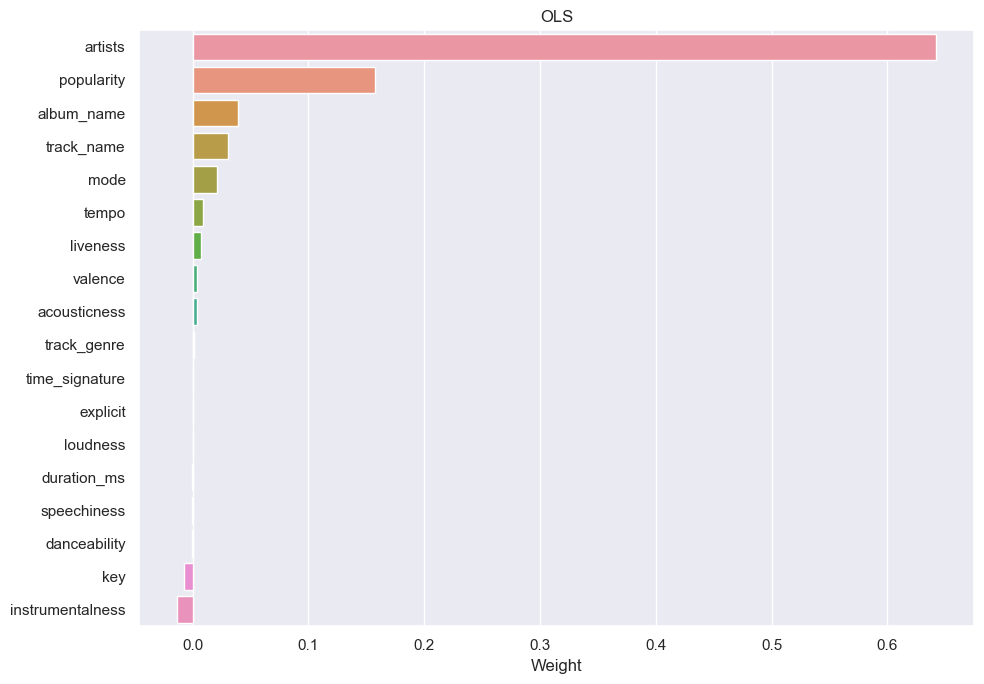

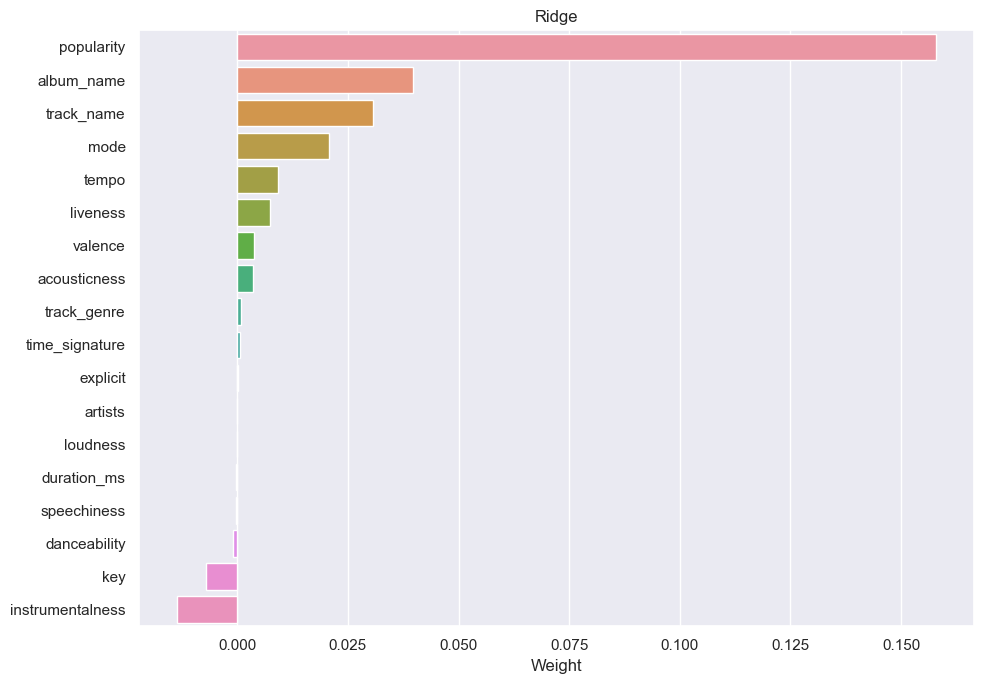

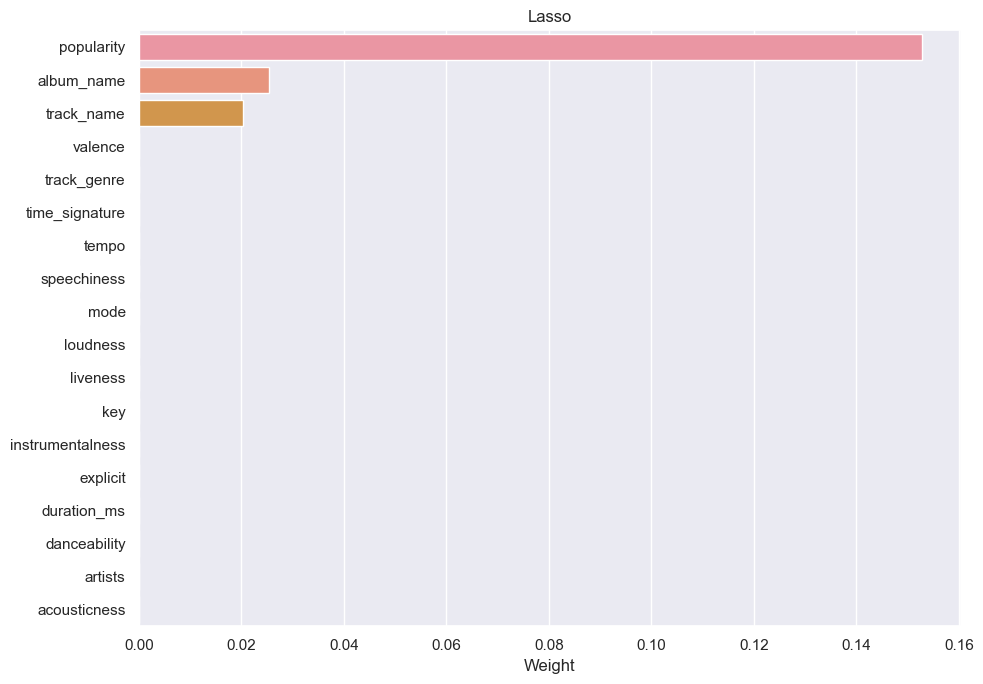

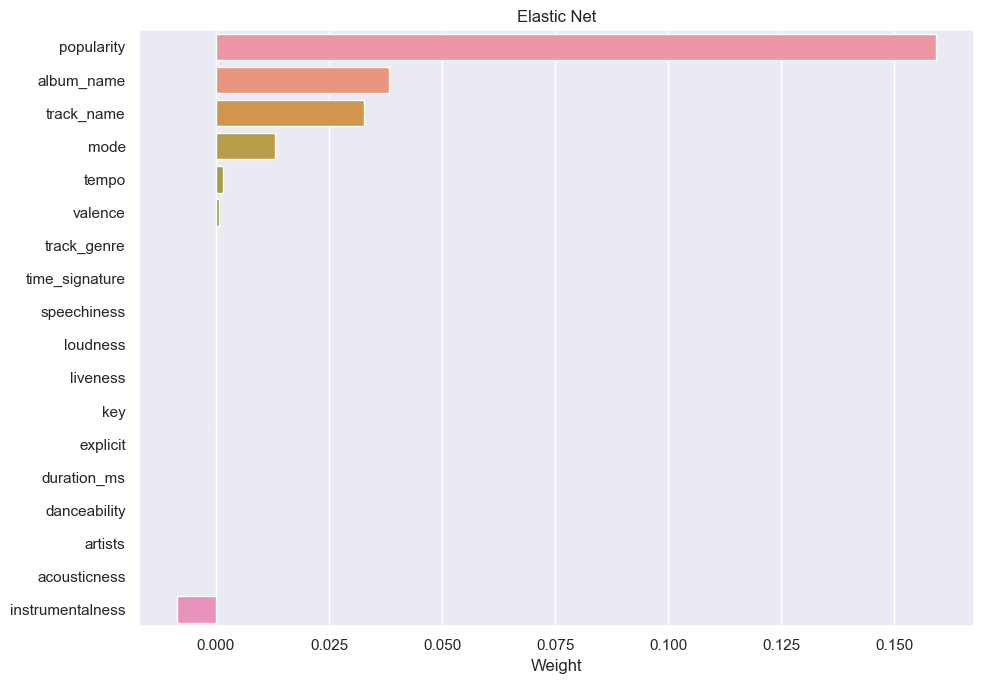

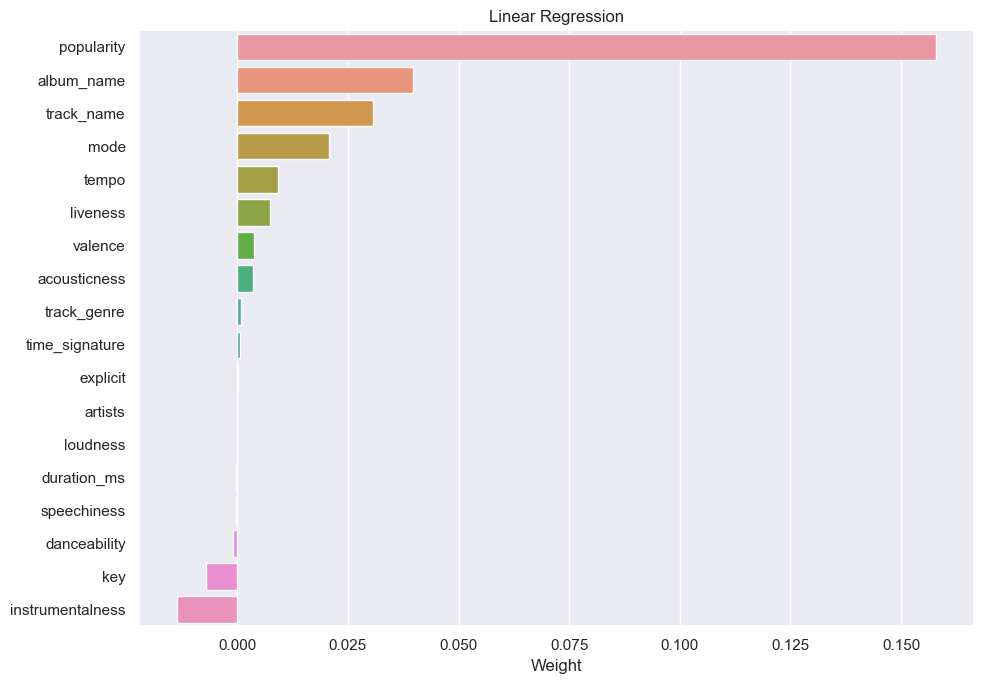

In [9]:
show_weights(X_train, model_ols.params, "OLS")
show_weights(X_train, model_ridge.coef_, "Ridge")
show_weights(X_train, model_lasso.coef_, "Lasso")
show_weights(X_train, model_en.coef_, "Elastic Net")
show_weights(X_train, model_lr.coef_, "Linear Regression")

На всех моделях, кроме OLS, наибольшим с большим отрывом весом обладает popularity, затем по нисходящей album_name и track_name, следующие имеют заметно меньший вес (на модели Lasso их веса нулевые). Логически это можно объяснить так: название альбома/трека зачастую соотносится с темой трека (и, соответственно, с его энергичностью), чаще всего более энергичные треки популярны.

Модели практически одинаковы, однако на Lasso и Elastic Net малые коэфф-ты зануляются, а на OLS artists обладает огромнейшим весом, при том, что на других моделях его вес стремится к нулю. Также максимальный вес на OLS ~= 0.6, на остальных 0.15.

#### 5. [1 балл] Реализуйте один из алгоритмов отбора признаков (Elimination by P-value, Forward elimination, Backward elimination), сделайте выводы.

In [10]:
def backward_elim(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = sm.add_constant(X_scaled)
    features_num = len(X_scaled[0])
    
    # Последовательно удаляем признаки с максимальным p-value
    for i in range(features_num):
        # Строим модель линейной регрессии
        model = sm.OLS(y, X_scaled).fit()
        # Находим признак с максимальным p-value
        max_feature = max(model.pvalues)
        # Если максимальный p-value больше 0.005, то удаляем признак с максимальным p-value
        if max_feature > 0.005:
            for j in range(features_num - i):
                if model.pvalues[j] == max_feature:
                    # Удаляем признак из матрицы признаков X и масштабированной матрицы признаков X_scaled
                    X = X.drop(columns=X.columns[j-1])
                    X_scaled = np.delete(X_scaled, j, 1)
    return X

X_opt = backward_elim(X_train, y_train)
print(f'Before optimisation with features num of {len(X_train.columns)}:\n{X_train.columns}\n')
print(f'After optimisation with features num of {len(X_opt.columns)}:\n{X_opt.columns}\n')

Before optimisation with features num of 18:
Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre'],
      dtype='object')

After optimisation with features num of 14:
Index(['artists', 'album_name', 'track_name', 'explicit', 'danceability',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')



In [11]:
X_test_opt = X_test
for val in X_test.columns:
    if val not in X_opt.columns:
        X_test_opt = X_test_opt.drop(columns=val)
X_opt = scaler.fit_transform(X_opt)
X_opt = sm.add_constant(X_opt)
X_test_opt = scaler.fit_transform(X_test_opt)
X_test_opt = sm.add_constant(X_test_opt)
y_pred_opt = sm.OLS(y_train, X_opt).fit().predict(X_test_opt)

print(f'Before optimisation: RMSE = {sqrt(mean_squared_error(y_test, y_pred))}, R^2 = {r2_score(y_test, y_pred)}\n')
print(f'After optimisation: RMSE = {sqrt(mean_squared_error(y_test, y_pred_opt))}, R^2 = {r2_score(y_test, y_pred_opt)}\n')

Before optimisation: RMSE = 0.054999452514911513, R^2 = 0.9520651218535235

After optimisation: RMSE = 0.05374807006446918, R^2 = 0.954221596352889



После проведения backward elimination оптимизации RMSE уменьшилась на 0.0012, а R^2 увеличилась на 0.002. Изменения являются положительными, но совсем малозначимыми.

#### 6. [1 балл] Найдите лучший (по RMSE) $\alpha$ для регрессиии Lasso, используя кросс-валидацию на 5 фолдов. Вы должны выбрать значение из промежутка $[10^{-4}, 10^{3}]$.

In [12]:
from sklearn.model_selection import cross_val_score

best_alpha = -1
best_rmse = -999999
# Перебираем значения alpha в диапазоне от 0.0001 до 1000.0 с шагом 10.0
for a in np.linspace(0.0001, 1000.0, num=100, endpoint=False):
    # Выполняем кросс-валидацию с помощью Lasso регрессии
    cv_score = cross_val_score(Lasso(alpha=a), X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    # Если текущее значение RMSE лучше предыдущего, то обновляем значения best_alpha и best_rmse
    if cv_score > best_rmse:
        best_rmse = cv_score
        best_alpha = a

print(best_alpha, best_rmse)

0.0001 -0.05336638413342828


In [13]:
model_lasso_2 = Lasso(alpha=best_alpha).fit(X_train_scaled, y_train)
y_pred = model_lasso_2.predict(X_test_scaled)
print(f'FOR sklearn.Lasso: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

FOR sklearn.Lasso: RMSE = 0.0537, R^2 = 0.9542



Лучшая по RMSE alpha для Lasso: 0.0001

## Градиентный спуск

#### 7. [3.5 балла] Имплементируйте  Ridge регрессию для MSE loss, обученную на градиентом спуске.


Все вычисления должны быть векторизованы, а циклы Python можно использовать только для итераций градиентного спуска. В качестве критерия остановки необходимо использовать (одновременно):

* проверка абсолютной нормы разницы весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, заданного параметром `tolerance`);

* достижение максимального количества итераций (например, 10000, заданного параметром `max_iter`).

Вам необходимо выполнить:

* Полный градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Стохастический градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ является оценкой градиента по набору объектов, выбранных случайным образом.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$

* Adagrad method:

$$
G_0 = 0, \\
G_{k + 1} = G_{k} + (\nabla_{w} Q(w_{k+1}))^2, \\
w_{k + 1} = w_{k} - \eta * \frac{\nabla_{w} Q(w_{k+1})}{\sqrt{G_{k+1} + \epsilon}}.
$$

Чтобы убедиться, что процесс оптимизации действительно выполняется, мы будем использовать атрибут класса `loss_history`. После вызова метода fit он должен содержать значения функции потерь для всех итераций, начиная с первой (до первого шага по антиградиенту).


Вам нужно инициализировать веса случайным вектором из нормального распределения. Ниже приведен шаблон, который должен содержать код, реализующий все варианты моделей.

In [78]:
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3, reg_cf=1e-3):
        """
        gd_type: str
            'GradientDescent', 'StochasticDescent', 'Momentum', 'Adagrad'
        delta: float
            proportion of object in a batch (for stochastic GD)
        tolerance: float
            for stopping gradient descent
        max_iter: int
            maximum number of steps in gradient descent
        w0: np.array of shape (d)
            init weights
        eta: float
            learning rate
        alpha: float
            momentum coefficient
        reg_cf: float
            regularization coefficient
        epsilon: float
            numerical stability
        """
        
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None
        self.reg_cf = reg_cf
        self.mean = None
        self.std = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        l, d = X.shape
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        X = (X - self.mean) / self.std
        self.w = self.w0 if self.w0 is not None else np.zeros(d)
        v = np.zeros(d)
        g = np.zeros(d)
        self.loss_history = []
        for i in range(self.max_iter):
            if self.gd_type == 'GradientDescent':
                g = self.calc_gradient(X, y)
                self.w -= self.eta * (g + self.reg_cf * self.w)
            elif self.gd_type == 'StochasticDescent':
                idx = np.random.choice(l, int(l * self.delta), replace=False)
                g = self.calc_gradient(X[idx], y[idx])
                self.w -= self.eta * (g + self.reg_cf * self.w)
            elif self.gd_type == 'Momentum':
                g = self.calc_gradient(X, y)
                v = self.alpha * v + self.eta * (g + self.reg_cf * self.w)
                self.w -= v
            elif self.gd_type == 'Adagrad':
                g = self.calc_gradient(X, y)
                g2 = g ** 2
                g2sum = np.sum(g2)
                self.w -= self.eta * (g + self.reg_cf * self.w) / np.sqrt(g2sum + 1e-8)
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            if i > 0 and abs(loss - self.loss_history[-2]) < self.tolerance:
                break
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        X = (X - self.mean) / self.std
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        l, d = X.shape
        return np.dot(X.T, np.dot(X, self.w) - y) / l
    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        l, d = X.shape
        return np.sum((np.dot(X, self.w) - y) ** 2) / (2 * l) + self.reg_cf * np.sum(self.w ** 2)

#### 8. [1 балл] Натренируйте и провалидируйте "ручные" модели на тех же даннных, сравните качество с моделями из Sklearn и StatsModels. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Соответствует ли оно вашим ожиданиям?

In [85]:
model_my_ridge = RidgeRegression().fit(X_train_scaled, y_train)
y_pred = model_my_ridge.predict(X_test_scaled)
print(f'FOR my RidgeRegression: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

y_pred = model_ridge.predict(X_test_scaled)
print(f'FOR sklearn.Ridge: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

model_ols = sm.OLS(y_train, X_train_scaled).fit()
y_pred = model_ols.predict(X_test_scaled)
print(f'FOR StatsModel.OLS: RMSE = {sqrt(mean_squared_error(y_test, y_pred)):.4f}, R^2 = {r2_score(y_test, y_pred):.4f}\n')

FOR my RidgeRegression: RMSE = 0.3294, R^2 = -0.7195

FOR sklearn.Ridge: RMSE = 0.0537, R^2 = 0.9542

FOR StatsModel.OLS: RMSE = 0.0537, R^2 = 0.9542



RMSE для написанного Ridge = 0.33, a R^2 = -0.72, что является ужасным результатом, намекающим на наличие ожибки в рассчётах.

#### 9. [1 балл] Постройте графики (там же) зависимости значения функции потерь от номера итерации для всех моделей (полного градиентого спуска, стохастического гс, Momentum и Adagrad). Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.


Не забывайте о том, как должен выглядеть *красивый* график!

In [ ]:
# TODO